In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd


In [3]:
file = np.load("./simulation_history.npz")

In [4]:
xs = file["Xs"]
us = file["Us"]
errors = file["errs"]

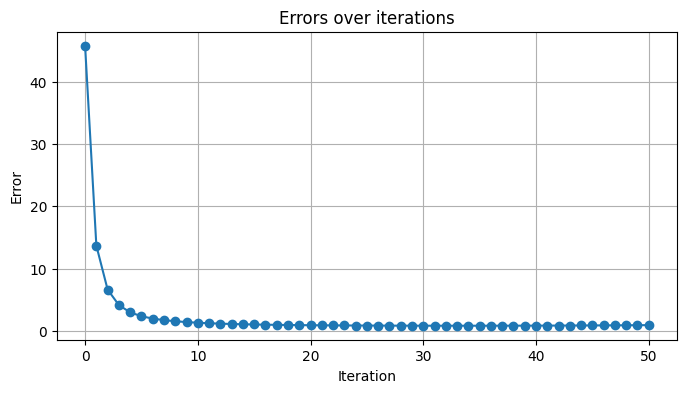

In [5]:
plt.figure(figsize=(8,4))
plt.plot(errors, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Errors over iterations')
plt.grid(True)
plt.show()

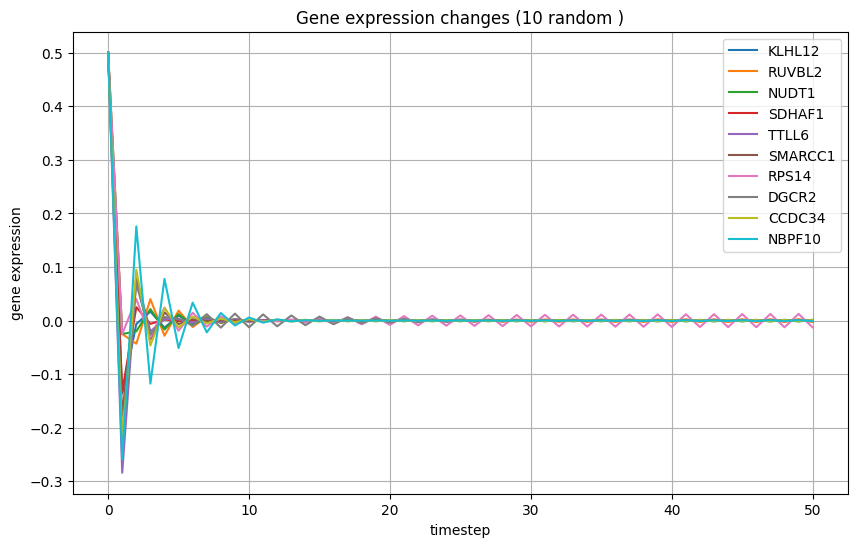

In [6]:
n_samples, n_states = xs.shape
idx = np.random.choice(n_states, size=10, replace=False)
genes = pd.read_csv('./o2/genes_order.csv', header=None)[0].astype(str)

plt.figure(figsize=(10,6))
x = np.arange(n_samples)
for i in idx:
    gene = genes.iloc[int(i)]
    plt.plot(x, xs[:, i], label=f'{gene}')
plt.xlabel('timestep')
plt.ylabel('gene expression')
plt.title('Gene expression changes (10 random )')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# select genes by how slowly they change over time (small absolute trend/slope),
# not by total amplitude. use linear slope magnitude as the metric.

# use existing time vector `x` (length n_samples)
t = x.astype(float)
t_centered = t - t.mean()
den = np.sum(t_centered**2)

# compute slope for each gene (vectorized)
slopes = t_centered.dot(xs) / den    # shape (n_states,)

# rank by absolute slope (smallest = slowest trend)
order_by_slope = np.argsort(np.abs(slopes))
top_n = 20
slow_idx = order_by_slope[:top_n]

# ensure supporting summary stats exist, compute if not
try:
    mad
except NameError:
    mad = np.mean(np.abs(np.diff(xs, axis=0)), axis=0)   # mean absolute step change

try:
    stds
except NameError:
    stds = np.std(xs, axis=0)

try:
    ranges
except NameError:
    ranges = np.ptp(xs, axis=0)

slow_genes = pd.DataFrame({
    'gene_index': slow_idx,
    'gene': genes.iloc[slow_idx].values,
    'slope': slopes[slow_idx],
    'abs_slope': np.abs(slopes[slow_idx]),
    'mean_abs_diff': mad[slow_idx],
    'std': stds[slow_idx],
    'range': ranges[slow_idx]
})

print(slow_genes)

    gene_index       gene     slope  abs_slope  mean_abs_diff       std  \
0         6036     RSPRY1 -0.000156   0.000156       0.272383  0.242518   
1         1504     COMMD5 -0.000174   0.000174       0.038545  0.099311   
2         2233     ERLIN1 -0.000181   0.000181       0.085320  0.136327   
3         3878     LSM14B -0.000228   0.000228       0.049292  0.099554   
4         5604     RAB11A -0.000233   0.000233       0.074657  0.121127   
5         6553     SNAPC2 -0.000240   0.000240       0.192192  0.129958   
6         1340     CHMP2B -0.000246   0.000246       0.051284  0.094085   
7         4469     NDFIP1 -0.000259   0.000259       0.062366  0.099747   
8         5816       RGS2 -0.000279   0.000279       0.086420  0.126357   
9         3754  LINC02913 -0.000282   0.000282       0.054829  0.101167   
10        3948     MAN1A1 -0.000305   0.000305       0.057310  0.100696   
11        1411       CLN3 -0.000307   0.000307       0.054638  0.095100   
12        8287    ZNF702P

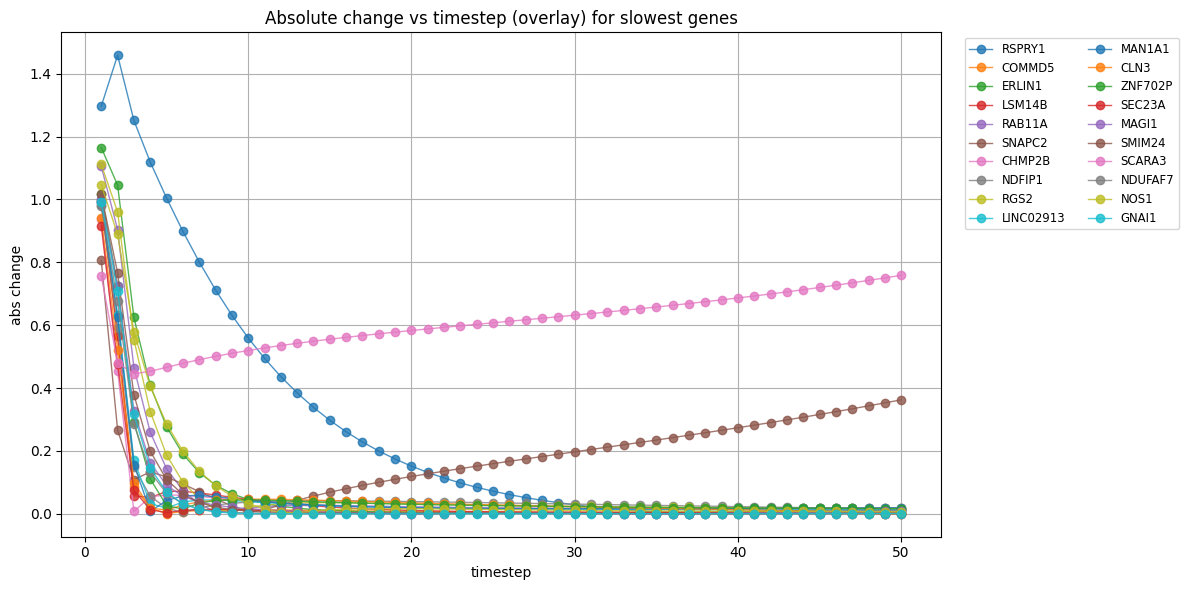

In [8]:
try:
    time_idx
except NameError:
    time_idx = t[1:]  # timesteps corresponding to the abs changes (n_samples-1)

try:
    changes
except NameError:
    changes = np.abs(np.diff(xs, axis=0))
plt.figure(figsize=(12,6))
for gidx in slow_idx:
    plt.plot(time_idx, changes[:, int(gidx)],
             marker='o', linestyle='-',
             alpha=0.8, linewidth=1,
             label=genes.iloc[int(gidx)])

plt.xlabel('timestep')
plt.ylabel('abs change')
plt.title('Absolute change vs timestep (overlay) for slowest genes')
plt.grid(True)
plt.legend(ncol=2, fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()
